In [1]:
import pandas as pd
from CTL.causal_tree_learn import CausalTree
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import round 2 data
rd2 = pd.read_csv('condensed_rd2.csv')
rd2 = rd2.set_index('childid')
X2 = rd2.iloc[:, :12].drop(['wi_new', 'sv_new'], axis=1)
X2.values

array([[-1.6 , -0.78, -1.77, ...,  1.  ,  1.  ,  1.  ],
       [-2.42, -2.24, -1.46, ...,  1.  ,  1.  ,  0.  ],
       [-1.  , -1.91,  0.41, ...,  0.  ,  1.  ,  1.  ],
       ...,
       [-0.88, -2.64,  1.31, ...,  1.  ,  0.  ,  0.  ],
       [-1.3 , -1.24, -0.84, ...,  0.  ,  0.  ,  0.  ],
       [ 0.06,  0.1 , -0.04, ...,  1.  ,  0.  ,  0.  ]])

In [3]:
# Separate data into x, treatment, and y

y = rd2['z_ppvt'].values
treatment = rd2['shecon3'].values
x = X2.values

np.random.seed(0)

In [4]:
# Split data into train and test
x_train, x_test, y_train, y_test, treat_train, treat_test = train_test_split(x, y, treatment,
                                                                             test_size=0.5, random_state=42)

In [5]:
x_train

array([[-0.7 , -0.93, -0.24, ...,  0.  ,  0.  ,  0.  ],
       [ 0.06, -0.28,  0.3 , ...,  1.  ,  1.  ,  0.  ],
       [-0.59,  0.24, -1.15, ...,  1.  ,  1.  ,  0.  ],
       ...,
       [ 0.06, -0.15,  0.19, ...,  1.  ,  0.  ,  0.  ],
       [-1.35, -1.53, -0.54, ...,  0.  ,  0.  ,  0.  ],
       [-1.74, -0.69, -2.11, ...,  1.  ,  1.  ,  0.  ]])

# Regular CTL

In [6]:
# train a conventional causal tree
ctl = CausalTree(magnitude=False)
ctl.fit(x_train, y_train, treat_train)
ctl.prune()
ctl_predict = ctl.predict(x_test)
ctl.assign_feature_names(X2.columns)


In [7]:
# Get feature combinations that lead to different groups / leaves of tree
ctl_features = ctl.get_features(x_train)

In [8]:
# Create dataframe of training data and group
train_data_ctl = pd.DataFrame(x_train, columns=X2.columns)
train_data_ctl['shock'] = treat_train
train_data_ctl['outcome'] = y_train
train_data_ctl['predicted ATE'] = ctl.predict(x_train)
train_data_ctl['group'] = ctl.get_groups(x_train)
train_data_ctl.head()

,zwfa,zhfa,zbfa,caredu,hq_new,cd_new,drwaterq_new,toiletq_new,elecq_new,cookingq_new,shock,outcome,predicted ATE,group
0,-0.70,-0.93,-0.24,0.0,0.270833,0.0,0.0,0.0,0.0,0.0,1,0.771780,0.785154,11.0
1,0.06,-0.28,0.30,0.0,0.316667,0.3,1.0,1.0,1.0,0.0,0,0.126715,-0.460232,7.0
2,-0.59,0.24,-1.15,0.0,0.283333,0.3,1.0,1.0,1.0,0.0,0,-0.357083,-1.170932,22.0
3,-0.08,0.46,-0.58,0.0,0.083333,0.2,0.0,0.0,0.0,0.0,0,-0.195817,0.860086,6.0
4,-3.25,-3.23,-1.58,0.0,0.305556,0.2,1.0,1.0,1.0,0.0,0,-0.115184,-0.103780,27.0


In [11]:
# Get average outcome for treated and untreated within each group
group_ates_ctl = train_data_ctl.iloc[:, -2:].groupby('group').mean()
group_ates_ctl.head()

,predicted ATE
group,
1.0,-0.896520
2.0,-1.092165
3.0,-0.725698
4.0,-1.259668
5.0,-0.742400


In [12]:
# Calculate overall Average Treatment Effect
overall_ate_ctl = sum(group_ates_ctl['predicted ATE'])/len(group_ates_ctl)
overall_ate_ctl

-0.41544446840113214

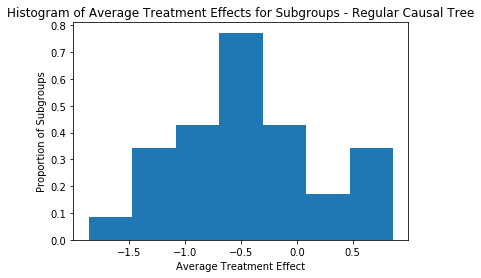

In [13]:
# Plot the distribution of ATEs over subgroups
plt.hist(group_ates_ctl['predicted ATE'], bins=7, density=True)
plt.title("Histogram of Average Treatment Effects for Subgroups - Regular Causal Tree")
plt.xlabel("Average Treatment Effect")
plt.ylabel("Proportion of Subgroups")
plt.show()

# Honest CTL

In [14]:
# honest CTL
cthl = CausalTree(honest=True)
cthl.fit(x_train, y_train, treat_train)
cthl.prune()
cthl_predict = cthl.predict(x_test)
cthl.assign_feature_names(X2.columns)

In [15]:
cthl_features = cthl.get_features(x_train)

In [16]:
# Create dataframe of training data and group
train_data_cthl = pd.DataFrame(x_train, columns=X2.columns)
train_data_cthl['shock'] = treat_train
train_data_cthl['predicted ATE'] = cthl.predict(x_train)
train_data_cthl['group'] = cthl.get_groups(x_train)
train_data_cthl.head()

,zwfa,zhfa,zbfa,caredu,hq_new,cd_new,drwaterq_new,toiletq_new,elecq_new,cookingq_new,shock,predicted ATE,group
0,-0.70,-0.93,-0.24,0.0,0.270833,0.0,0.0,0.0,0.0,0.0,1,-0.551753,2.0
1,0.06,-0.28,0.30,0.0,0.316667,0.3,1.0,1.0,1.0,0.0,0,-0.551753,2.0
2,-0.59,0.24,-1.15,0.0,0.283333,0.3,1.0,1.0,1.0,0.0,0,-0.551753,2.0
3,-0.08,0.46,-0.58,0.0,0.083333,0.2,0.0,0.0,0.0,0.0,0,-0.551753,2.0
4,-3.25,-3.23,-1.58,0.0,0.305556,0.2,1.0,1.0,1.0,0.0,0,-0.551753,2.0


In [17]:
# Get average outcome for treated and untreated within each group
group_ates_cthl = train_data_cthl.iloc[:, -2:].groupby('group').mean()
group_ates_cthl

,predicted ATE
group,
1.0,-1.026728
2.0,-0.551753


In [18]:
overall_ate_cthl = sum(group_ates_cthl['predicted ATE'])/len(group_ates_cthl)
overall_ate_cthl

-0.7892402403723573

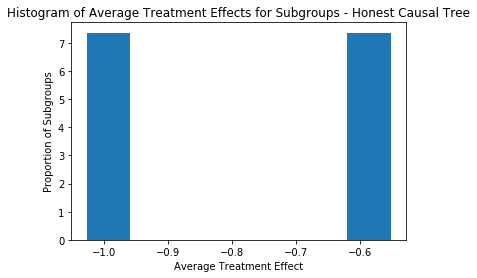

In [19]:
plt.hist(group_ates_cthl['predicted ATE'], bins=7, density=True)
plt.title("Histogram of Average Treatment Effects for Subgroups - Honest Causal Tree")
plt.xlabel("Average Treatment Effect")
plt.ylabel("Proportion of Subgroups")
plt.show()

# Val Honest CTL

In [20]:
cthv = CausalTree(val_honest=True)
cthv.fit(x_train, y_train, treat_train)
cthv.prune()
cthv_predict = cthv.predict(x_test)
cthv.assign_feature_names(X2.columns)

In [21]:
cthv_features = cthv.get_features(x_train)

In [22]:
# Create dataframe of training data and group
train_data_cthv = pd.DataFrame(x_train, columns=X2.columns)
train_data_cthv['shock'] = treat_train
train_data_cthv['predicted ATE'] = cthv.predict(x_train)
train_data_cthv['group'] = cthv.get_groups(x_train)
train_data_cthv.head()

,zwfa,zhfa,zbfa,caredu,hq_new,cd_new,drwaterq_new,toiletq_new,elecq_new,cookingq_new,shock,predicted ATE,group
0,-0.70,-0.93,-0.24,0.0,0.270833,0.0,0.0,0.0,0.0,0.0,1,-0.378683,1.0
1,0.06,-0.28,0.30,0.0,0.316667,0.3,1.0,1.0,1.0,0.0,0,-0.378683,1.0
2,-0.59,0.24,-1.15,0.0,0.283333,0.3,1.0,1.0,1.0,0.0,0,-0.583473,5.0
3,-0.08,0.46,-0.58,0.0,0.083333,0.2,0.0,0.0,0.0,0.0,0,-0.378683,1.0
4,-3.25,-3.23,-1.58,0.0,0.305556,0.2,1.0,1.0,1.0,0.0,0,-0.583473,5.0


In [23]:
# Get average outcome for treated and untreated within each group
group_ates_cthv = train_data_cthv.iloc[:, -2:].groupby('group').mean()
group_ates_cthv

,predicted ATE
group,
1.0,-0.378683
2.0,-0.003665
4.0,-1.052132
5.0,-0.583473
7.0,-0.180081


In [25]:
overall_ate_cthv = np.mean(group_ates_cthv['predicted ATE'])
overall_ate_cthv

-0.43960664067620037

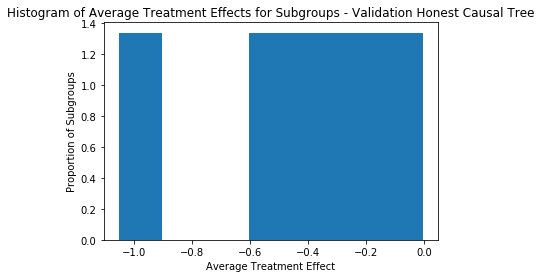

In [26]:
plt.hist(group_ates_cthv['predicted ATE'], bins=7, density=True)
plt.title("Histogram of Average Treatment Effects for Subgroups - Validation Honest Causal Tree")
plt.xlabel("Average Treatment Effect")
plt.ylabel("Proportion of Subgroups")
plt.show()

In [27]:
ctl.plot_tree(features=X2.columns, filename="young_lives/bin_tree", show_effect=True)
cthl.plot_tree(features=X2.columns, filename="young_lives/bin_tree_honest_learn", show_effect=True)
cthv.plot_tree(features=X2.columns, filename="young_lives/bin_tree_valhonest_learn", show_effect=True)